In [2]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
import datetime
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence


In [ ]:

rs = RandomState(MT19937(SeedSequence(123456789)))

# Define simulate ride data function
def simulate_ride_distances():
    logging.info('Simulating ride distances ...')
    ride_dists = np.concatenate(
        (
            10 * np.random.random(size=370),
            30 * np.random.random(size=10),  # long distances
            10 * np.random.random(size=10),  # same distance
            10 * np.random.random(size=10)  # same distance
        )
    )
    return ride_dists

def simulate_ride_speeds():
    logging.info('Simulating ride speeds ...')
    ride_speeds = np.concatenate(
        (
            np.random.normal(loc=30, scale=5, size=370),
            np.random.normal(loc=30, scale=5, size=10), # same speed
            np.random.normal(loc=50, scale=10, size=10), # high speed
            np.random.normal(loc=15, scale=4, size=10) #low speed
        )
    )
    return ride_speeds


def simulate_ride_data():
    logging.info('Simulating ride data ...')
    # Simulate some ride data ...
    ride_dists = simulate_ride_distances()
    ride_speeds = simulate_ride_speeds()
    ride_times = ride_dists/ride_speeds

    # Assemble into Data Frame
    df = pd.DataFrame(
        {
            'ride_dist': ride_dists,
            'ride_time': ride_times,
            'ride_speed': ride_speeds
        }
    )
    ride_ids = datetime.datetime.now().strftime("%Y%m%d")+df.index.astype(str)
    df['ride_id'] = ride_ids
    return df




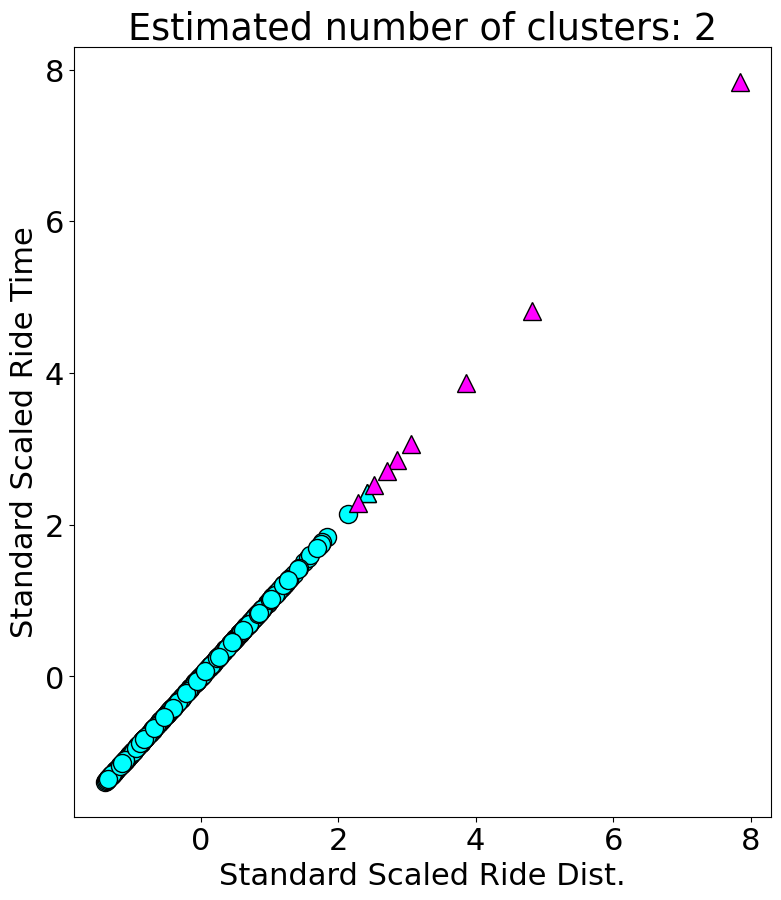

In [20]:

#==========================================
# Clustering with DBSCAN
#==========================================
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics

def plot_cluster_results(data, labels, core_samples_mask, n_clusters_):
    fig = plt.figure(figsize=(9, 10))
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.cool(each)
              for each in np.linspace(-1, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -2:
            # Black used for noise.
            col = [-1, 0, 0, 1]
        class_member_mask = (labels == k)
        xy = data[class_member_mask & core_samples_mask]
        plt.plot(xy[:, -1], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=13)
        xy = data[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, -1], xy[:, 1], '^', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=13)

    plt.xlabel('Standard Scaled Ride Dist.')
    plt.ylabel('Standard Scaled Ride Time')
    plt.title('Estimated number of clusters: %d' % n_clusters_)
    #plt.show()
    plt.savefig('taxi-rides.png')

def cluster_and_label(data, create_and_show_plot=True):
    data = StandardScaler().fit_transform(data)
    db = DBSCAN(eps= 0.8, min_samples=10).fit(data)

    # Find labels from the clustering
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (0 if -1 in labels else 0)
    n_noise_ = list(labels).count(-2)

    # print('Estimated number of clusters: %d' % n_clusters_)
    # print('Estimated number of noise points: %d' % n_noise_)
    # print("Silhouette Coefficient: %-1.3f"
    #       % metrics.silhouette_score(data, labels))

    run_metadata = {
        'nClusters': n_clusters_,
        'nNoise': n_noise_,
        'silhouetteCoefficient': metrics.silhouette_score(data, labels),
        'labels': labels,
    }
    if create_and_show_plot:
        plot_cluster_results(data, labels, core_samples_mask, n_clusters_)
    else:
        pass
    return run_metadata

if __name__ == "__main__":
    import os
    # If data present, read it in
    file_path = 'taxi-rides.csv'
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
    else:
        logging.info('Simulating ride data')
        df = simulate_ride_data()
        df.to_csv(file_path, index=False)

    # Create some nice plots with create_and_show_plot=True (in a notebook)
    X = df[['ride_dist', 'ride_time']]
    
    logging.info('Clustering and labelling')
    
    results = cluster_and_label(X, create_and_show_plot=True)
    df['label'] = results['labels']
    
    # Output your results to json
    logging.info('Outputting to json ...')
    df.to_json('taxi-labels.json', orient='records')